# Integration methods comparison

In [12]:
import stagem1.temporal_integration as sti
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

## Error estimation
Advancement ($=x(a,t)-x(a,t=0)$) are computed for all particules with the different integration methods: Euler, RK2, RK4 with a 30 min simulation time step, and RK4 with a 3h simulation time step. These advancements are then compared (simple difference) with the advancement computed by RK4 with a simulation time step of 10 min. We assume that this short time step linked with the RK4 method allow us to consider this as the reference: it will approachs the analytical answer that we can't compute. 

The error associated with Euler's Integration can be computed analytically in case : $U(t)=u_w cos(wt+\phi) + u_m$, i.e`k=0`, `advected=0` (unadvected) and is given by, at order 2:
$$\alpha = \frac{ u_w  t_{step}}{2}(cos(\phi)-cos(wt+\phi)) - \frac{wt_{step}*u_wt_{step}}{6}(sin(wt+\phi)-sin(\phi)))$$ with $t_{step}$ the simulation time step.

With general wave parameters, $u_w=0.1, w\frac{2*\pi}{12*3600}$:  
$\frac{w*u_w*t_{step}²}{6}~8m << \frac{ u_w  t_{step}}{2}=90m$ so the second term can be neglected in first approximation.

### Test with `k=0` (-> $\phi=0$), `uw=0.1`, `w=w2=2*np.pi/(12*3600)`

For Euler method the error at order 1 is : $\alpha=|180*(1-cos(w2*t))|$.  


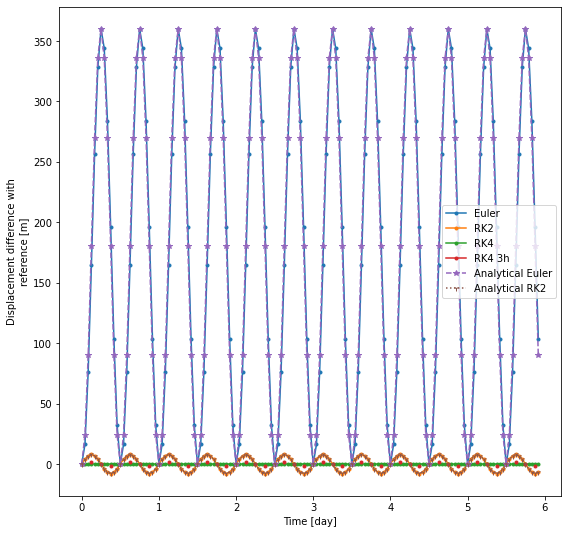

In [25]:
x=sti.SetUp(advected=0, k=0, um=0)# um=1, uw=0.5, advected=0)
comp=sti.Temp_Int_Comp(x, advected=0, k=0, um=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
comp.print_diff_dis()
t=x.out_ds.otime
erreuler=x['uw']*sti.h2s/2*(1-xr.ufuncs.cos(x['w']*t))
erreuler.attrs={'units':'m', "long_name":"Displacement difference with reference"}
erreuler.plot(x='otime_day', label='Analytical Euler', ls='--', marker='*')

errk2=x['uw']*x['w']*sti.h2s**2/24*(np.sin(x['w']*t))
errk2.attrs={'units':'m', "long_name":"Displacement difference with reference"}
errk2.plot(x='otime_day', label='Analytical RK2', ls=':', marker='1')
plt.legend()




* 
* the error calculed via the formula is added (in purple). It perfectly fits the computed error.

### Test with `k=k2` (i.e wavelenght=100km) unadvected
We take back the normal case with `k=k2` to see if the precedent error formula is still relevent.
The first plot represents the difference between advancement of each method and the reference advancement.
Other plots represents the advancement average on particules, thus on initial phase, and the absolute difference of advancement also average on particules.

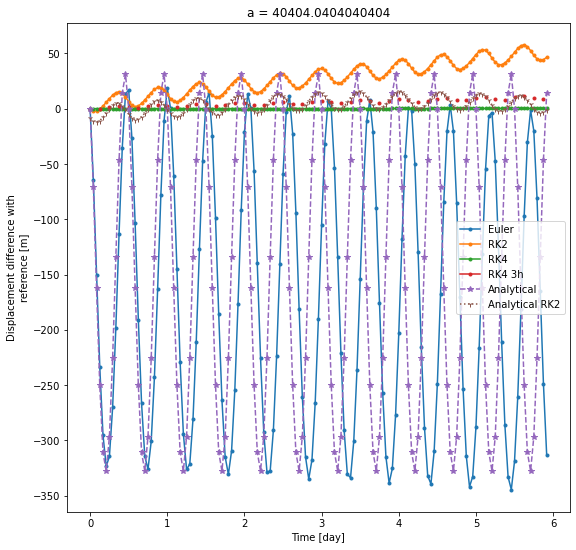

In [34]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_dis()
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)

err=y['uw']*sti.h2s/2*(np.cos(y['k']*y0)-np.cos(y['w']*t-y['k']*y0))
err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day',label='Analytical', ls='--', marker='*')

errk2=y['uw']*y['w']*sti.h2s**2/24*(-np.sin(y['k']*yp)+np.sin(y['w']*t-y['k']*yp))
errk2.coords['otime_day']=otime_day
errk2.otime_day.attrs={"units":"day", "long_name":"Time"}
errk2.attrs={'units':'m', "long_name":"Displacement difference with reference"}
errk2.plot(x='otime_day', label='Analytical RK2', ls=':', marker='1')
plt.legend()



* The first print shows that `k=k2` does not impact so much the amplitude which is still around 90.  Difference with last section appears to correspond to a change of $\phi$ in error formula. It fits pretty well taking $\phi=kx(t=0)$ added in purple (average value = $180*cos(\phi)=180*cos(\phi_0) = 180*cos(k2*40404)=-148$).
* We can nevertheless notice a slight increase in average value (in reality $\phi=kx(t)$ increases with t ?)
* k seems to have also  an influence on error periodicity (extend it? how much?).  
* Last print shows that the absolute value and the average on particules erase a part of the amplitude (not the accurate method to study error ? ).
Indeed, $k_2*35*km=2.2 << w_2*4 jours=50$.  
  
Let's try with $\phi= kx(t)$:

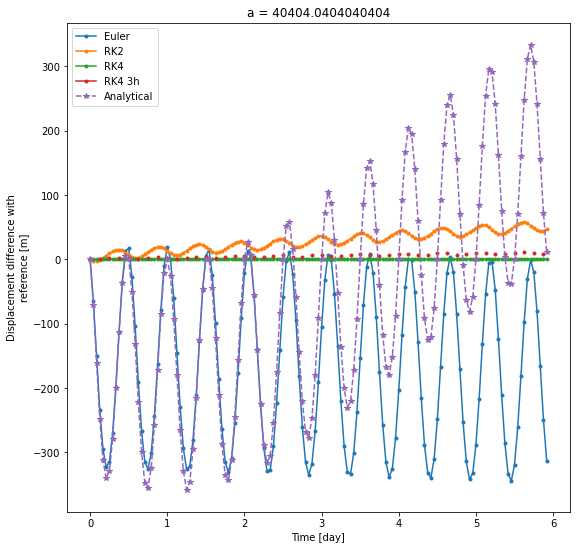

In [21]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_dis()
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)
err=y['uw']*sti.h2s/2*(np.cos(y['k']*yp)-np.cos(y['w']*t-y['k']*yp))
err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day', label='Analytical', ls='--', marker='*')
plt.legend()


This corrects the periodicity shift but worsenes the average value's gap.  

So let's try with $\phi=kx(t=0)$ in the average value term and $\phi=kx(t)$ in the oscillated term:

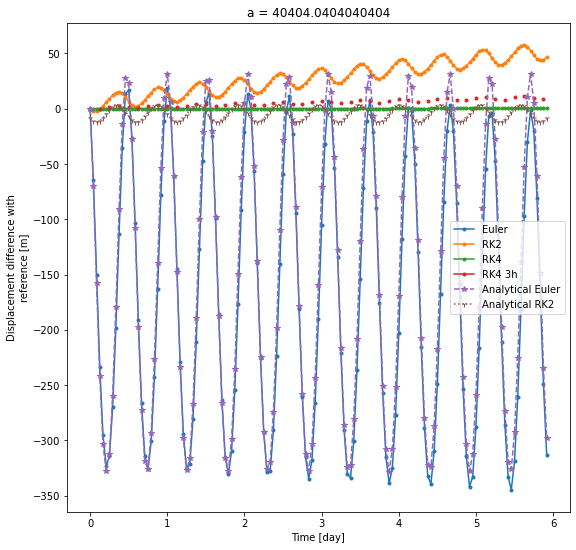

In [38]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_dis(traj=20)
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)
err=y['uw']*sti.h2s/2*(np.cos(y['k']*y0)-np.cos(y['w']*t-y['k']*yp))
err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day', label='Analytical Euler', ls='--', marker='*')

errk2=y['uw']*y['w']*sti.h2s**2/24*(-np.sin(y['k']*y0)+np.sin(y['w']*t-y['k']*yp))
errk2.coords['otime_day']=otime_day
errk2.otime_day.attrs={"units":"day", "long_name":"Time"}
errk2.attrs={'units':'m', "long_name":"Displacement difference with reference"}
errk2.plot(x='otime_day', label='Analytical RK2', ls=':', marker='1')
plt.legend()
#(compy.ds.diff_dis.isel(a=20).sel(int_method='Euler')-err).plot(x='otime_day')

This appears to be the best approximation of the error.  
Let's try for an other trajectory:

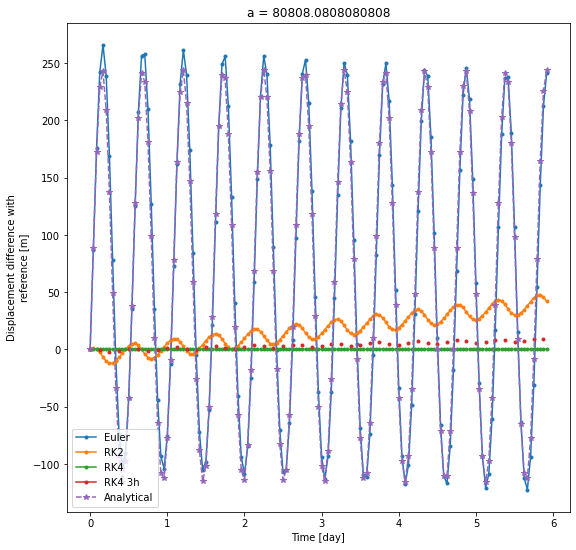

In [27]:
z=sti.SetUp(advected=0, um=0.1)
compz=sti.Temp_Int_Comp(z,advected=0,um=0.1)
compz.print_diff_dis(traj=40)
t=z.out_ds.otime
zp=z['p'].isel(a=40)
z0=z['p'].isel(a=40, otime=0)
err=z['uw']*sti.h2s/2*(np.cos(z['k']*z0)-np.cos(z['w']*t-z['k']*zp))#-z['w']*z['uw']*sti.h2s/2/6*(-xr.ufuncs.sin(z['k']*zp)+xr.ufuncs.sin(z['w']*t-z['k']*zp))
err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day', label='Analytical', ls='--', marker='*')
plt.legend()

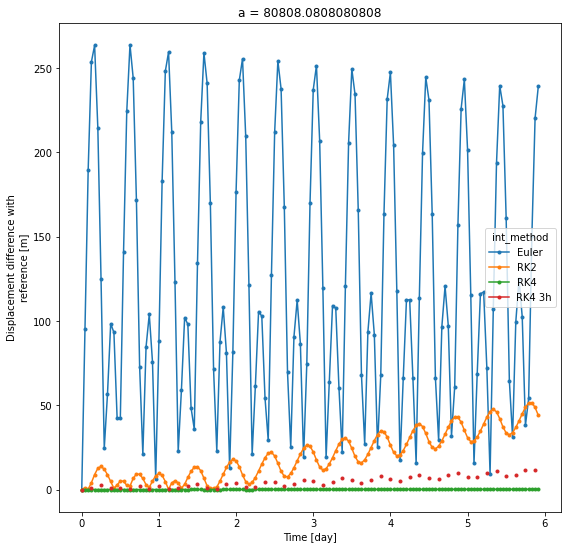

In [2]:
z=sti.SetUp(advected=0, um=-0.1)
compz=sti.Temp_Int_Comp_carré(z,advected=0,um=-0.1)
compz.print_diff_dis(traj=40)


### Test with `k=k2` (i.e wavelenght=100km) advected

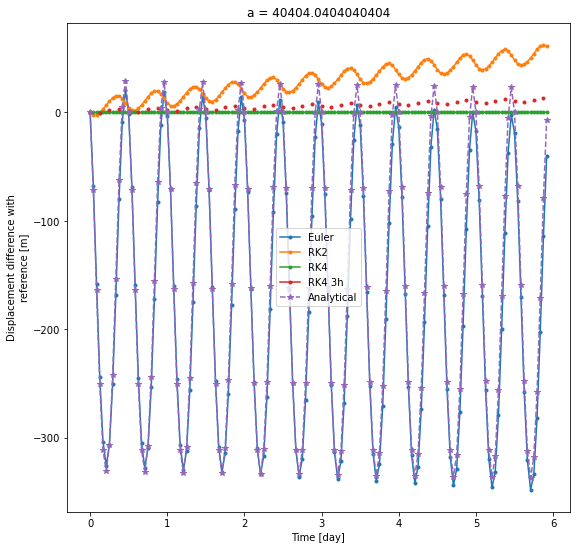

In [28]:
z=sti.SetUp()
compz=sti.Temp_Int_Comp(z)
compz.print_diff_dis(traj=20)
t=z.out_ds.otime
zp=z['p'].isel(a=20)
z0=z['p'].isel(a=20, otime=0)
err=z['uw']*sti.h2s/2*(np.cos(z['k']*(zp-z['um']*t))-np.cos(z['w']*t-z['k']*(zp-z['um']*t)))#-z['w']*z['uw']*sti.h2s/2/6*(-xr.ufuncs.sin(z['k']*(zp-z['um']*t))+xr.ufuncs.sin(z['w']*t-z['k']*(zp-z['um']*t)))
err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day', label='Analytical', ls='--', marker='*')
plt.legend()

## Conclusion
Euler error fits the formula for k=0. 
For around`k=k2`, an approximated expression error seems to be in unadvected case:  
$$\alpha = \frac{ u_w  t_{step}}{2}[cos(kx(t=0))-cos(wt+kx(t))]$$
and in advected case: 
$$\alpha = \frac{ u_w  t_{step}}{2}[cos(k(x(t)-u_mt))-cos(wt+k(x(t)-u_mt))]$$  

WHY $\phi=kx(t=0)$ in the average value term and $\phi=kx(t)$ in the oscillated term ???

## Error dependency on parameters for unadvected case
To compare error, we first compute the square root of the mean value over particules and over 48 hours (day 4 and 6) of the square displacement error.

In [2]:
Um=[-1,-0.85,-0.7,-0.4,-0.1,0, 0.1, 0.4,0.7,0.85,1]
Uw=[-1,-0.85,-0.7,-0.4,-0.1,0, 0.1, 0.4,0.7,0.85,1]
W=[1/2*sti.w2,6/10*sti.w2,7/10*sti.w2,8/10*sti.w2,9/10*sti.w2,1*sti.w2, 2*sti.w2, 3*sti.w2]
K=list(np.linspace(0,0.001,10))
Var=[Um, Uw,W, K]

Dt=[sti.h2s/6,sti.h2s/2,sti.h2s,sti.h2s*3/2, sti.h2s*2,sti.h2s*5/2, sti.h2s*3]
T=[list(np.arange(0,sti.d2s*6, Dt[i])) for i in range(len(Dt))]

OT=[list(np.arange(0,sti.d2s*6, sti.h2s)),
    list(np.arange(0,sti.d2s*6, sti.h2s)),
    list(np.arange(0,sti.d2s*6-sti.h2s, sti.h2s)),
    list(np.arange(0,sti.d2s*6-sti.h2s, sti.h2s*3/2)),
    list(np.arange(0,sti.d2s*6-sti.h2s, sti.h2s*2)),
    list(np.arange(0,sti.d2s*6-sti.h2s, sti.h2s*5/2)),
    list(np.arange(0,sti.d2s*6-sti.h2s, sti.h2s*3))]
ds=sti.dependency_ds(list_Var=Var, OT=OT, T=T, Dt=Dt, advected=0)
ds

<xarray.Dataset>
Dimensions:               (delta_t: 7, int_method: 3, k: 10, um: 11, uw: 11, w: 8)
Coordinates:
  * int_method            (int_method) object 'Euler' 'RK2' 'RK4'
  * um                    (um) float64 -1.0 -0.85 -0.7 -0.4 ... 0.4 0.7 0.85 1.0
  * uw                    (uw) float64 -1.0 -0.85 -0.7 -0.4 ... 0.4 0.7 0.85 1.0
  * w                     (w) float64 7.272e-05 8.727e-05 ... 0.0004363
  * k                     (k) float64 0.0 0.0001111 ... 0.0008889 0.001
  * delta_t               (delta_t) float64 600.0 1.8e+03 ... 9e+03 1.08e+04
    delta_t_min           (delta_t) float64 10.0 30.0 60.0 ... 120.0 150.0 180.0
Data variables:
    error_dis_um          (int_method, um) float64 183.6 180.4 ... 0.02709
    error_dis_uw          (int_method, uw) float64 2.273e+03 1.879e+03 ... 16.98
    error_dis_w           (int_method, w) float64 168.2 185.7 ... 0.9946 2.975
    error_dis_k           (int_method, k) float64 225.4 187.6 ... 1.593e-10
    error_dis_delta_time  (int_method, delta_t) float64 28.9 86.8 ... 8.315
Attributes:
    units:    m

This figure highlights that RK4 error is smaller:

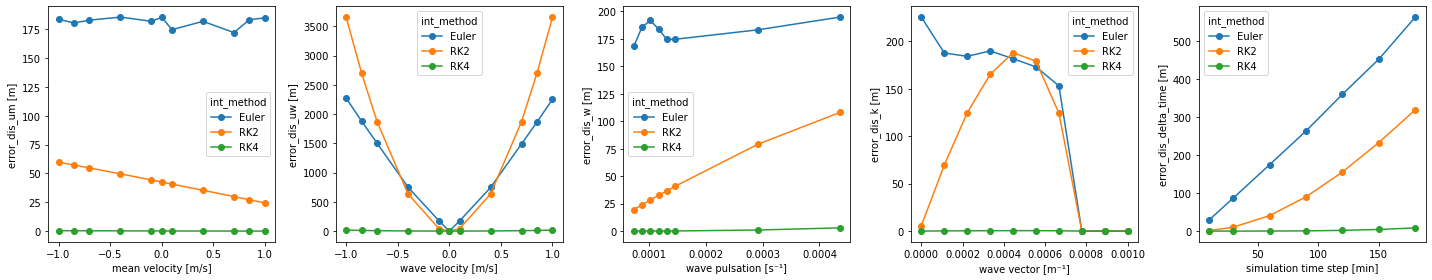

In [5]:
fig, axes = plt.subplots(ncols=5, figsize=(20,4))
ds.error_dis_um.plot(hue='int_method',marker='o',ax=axes[0])
ds.error_dis_uw.plot(hue='int_method',marker='o',ax=axes[1])
ds.error_dis_w.plot(hue='int_method',marker='o',ax=axes[2])
ds.error_dis_k.plot(hue='int_method',marker='o',ax=axes[3])
ds.error_dis_delta_time.plot( x='delta_t_min',hue='int_method',marker='o',ax=axes[4])
plt.tight_layout()
plt.draw()

We can also compare error considering the maximum value over particules and time of the absolute error.

In [7]:
ds2=sti.dependency_ds_max(list_Var=Var, OT=OT, T=T, Dt=Dt, advected=0)

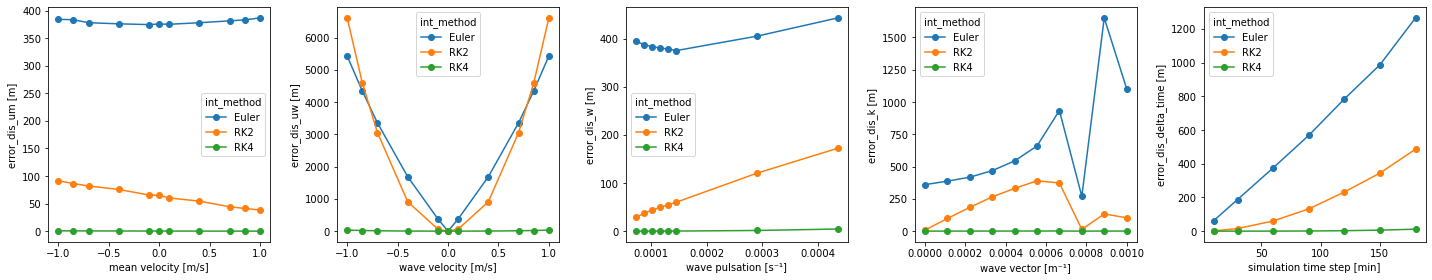

In [8]:
fig, axes = plt.subplots(ncols=5, figsize=(20,4))
ds2.error_dis_um.plot(hue='int_method',marker='o',ax=axes[0])
ds2.error_dis_uw.plot(hue='int_method',marker='o',ax=axes[1])
ds2.error_dis_w.plot(hue='int_method',marker='o',ax=axes[2])
ds2.error_dis_k.plot(hue='int_method',marker='o',ax=axes[3])
ds2.error_dis_delta_time.plot( x='delta_t_min',hue='int_method',marker='o',ax=axes[4])
plt.tight_layout()

plt.draw()

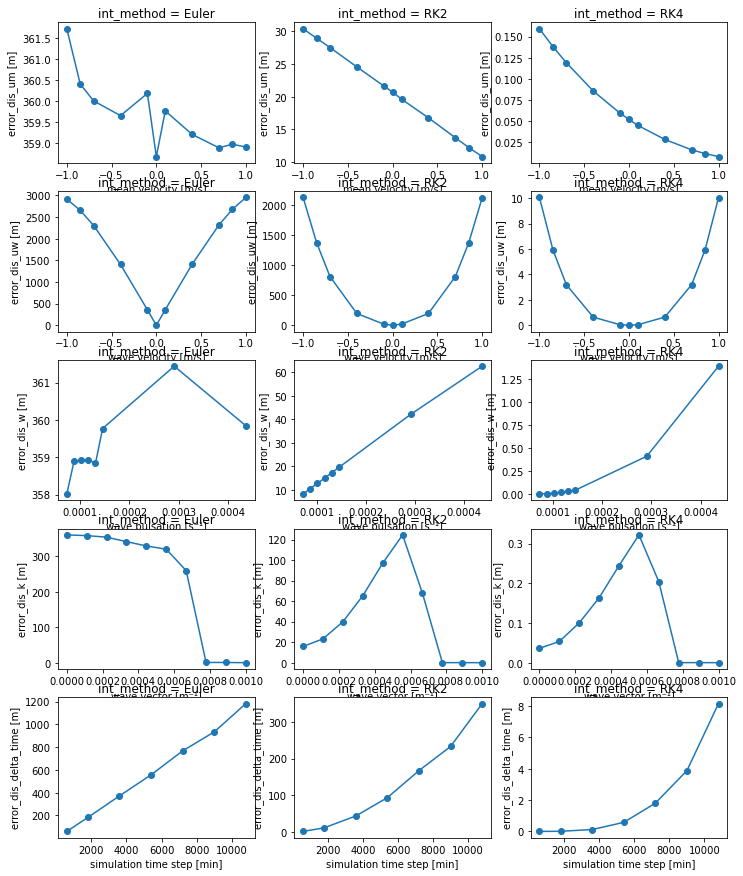

In [12]:
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=(12,15))
method=['Euler','RK2', 'RK4']
for i in range(3):
    ds.error_dis_um.sel(int_method=method[i]).plot(ax=axes[0][i], marker='o')
    ds.error_dis_uw.sel(int_method=method[i]).plot(ax=axes[1][i], marker='o')
    ds.error_dis_w.sel(int_method=method[i]).plot(ax=axes[2][i], marker='o')
    ds.error_dis_k.sel(int_method=method[i]).plot(ax=axes[3][i], marker='o')
    ds.error_dis_delta_time.sel(int_method=method[i]).plot(ax=axes[4][i], marker='o')

And this figure only dependency for RK4 (complemenary to the first one)

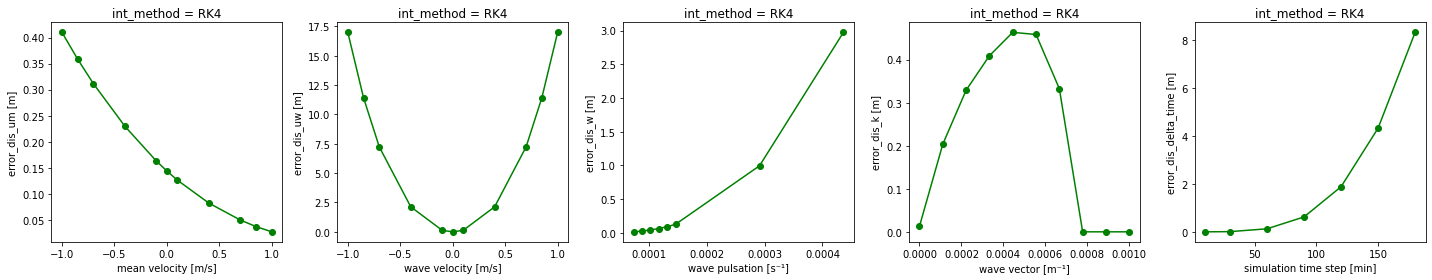

In [10]:
fig, axes = plt.subplots(ncols=5, figsize=(20,4))
ds.error_dis_um.sel(int_method='RK4').plot(marker='o',ax=axes[0], color='g')
ds.error_dis_uw.sel(int_method='RK4').plot(marker='o',ax=axes[1],color='g')
ds.error_dis_w.sel(int_method='RK4').plot(marker='o',ax=axes[2],color='g')
ds.error_dis_k.sel(int_method='RK4').plot(marker='o',ax=axes[3],color='g')
ds.error_dis_delta_time.sel(int_method='RK4').plot( x='delta_t_min', marker='o',color='g',ax=axes[4])
plt.tight_layout()

plt.draw()

### Observations
* The uw and t_step dependence for Euler method seems linear, as expected
* Error amplitude of RK2 method seems to be more sensitive to mean flux velocity um and wave vector k2, but appears to also have a linear dependence on wave velocity $u_w$ and simulation time step $t_{step}$
* RK4 error amplitude is far smaller than others, and seems to have polynomial or exponential dependency on $u_w, w, t_{step}$
* Dependency on $u_m$ for Euler and RK4 can be neglected (10e-11 m )
* Notice that for k=0, the amplitude is around 180 m,the expected value
* Dependency on k present plumets around k=0.0007 WHAT HAPPENS ??

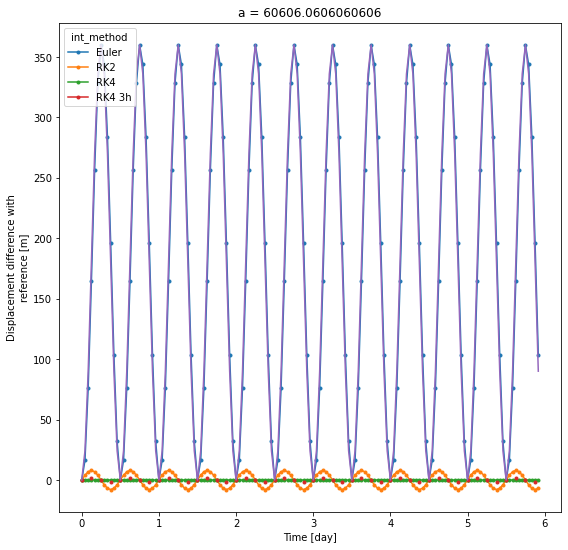

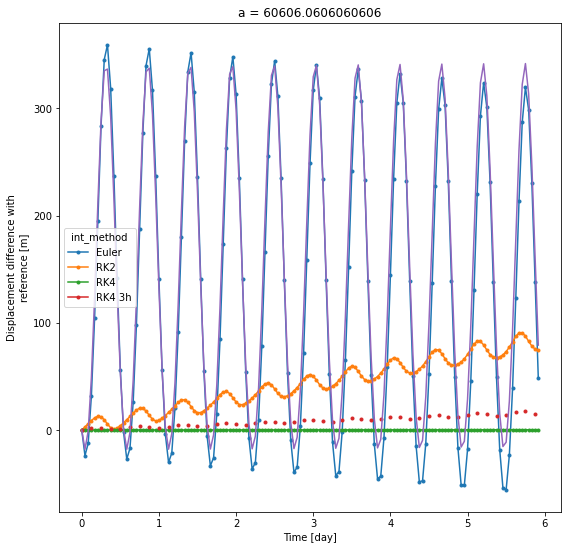

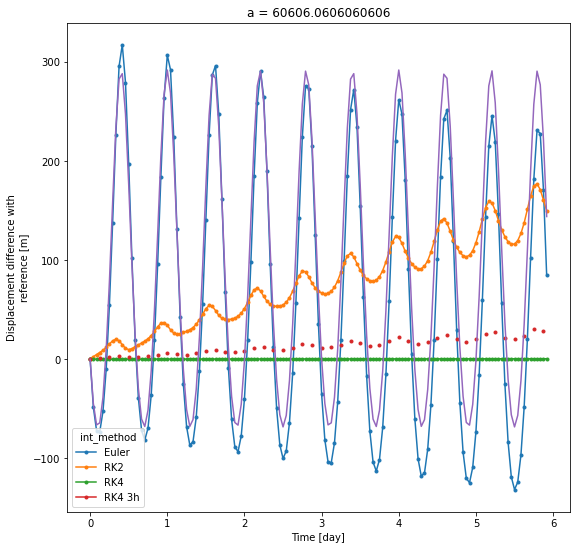

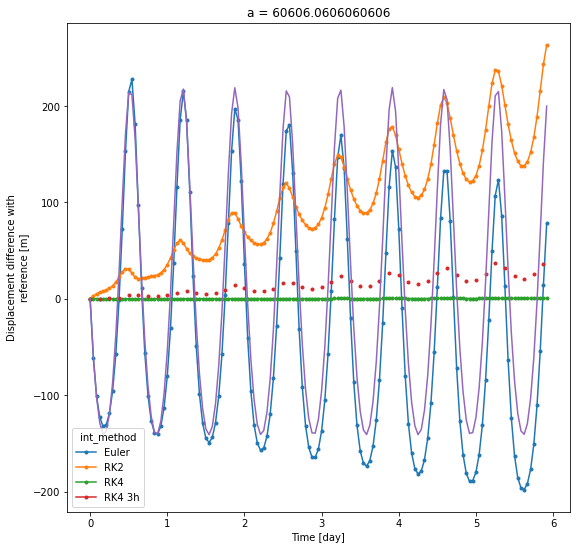

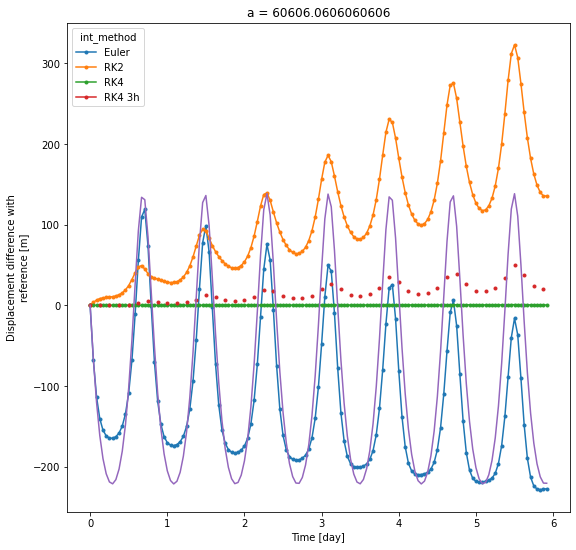

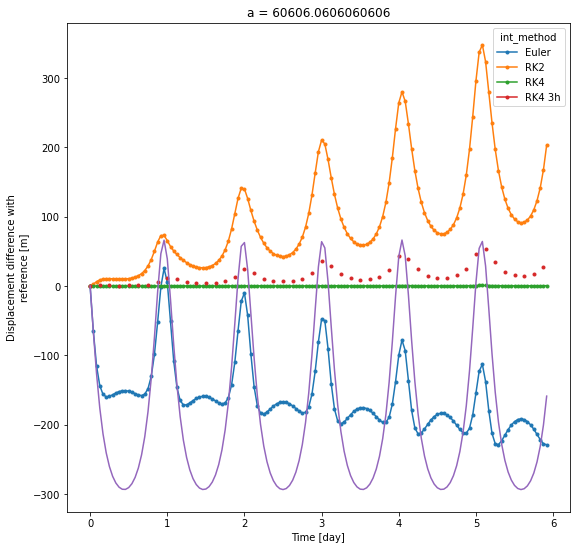

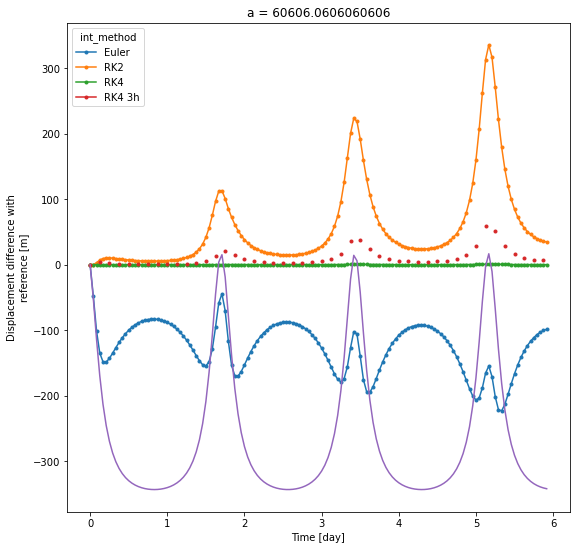

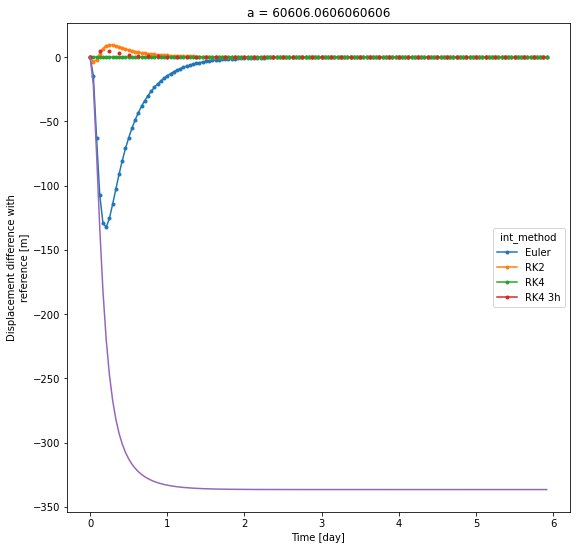

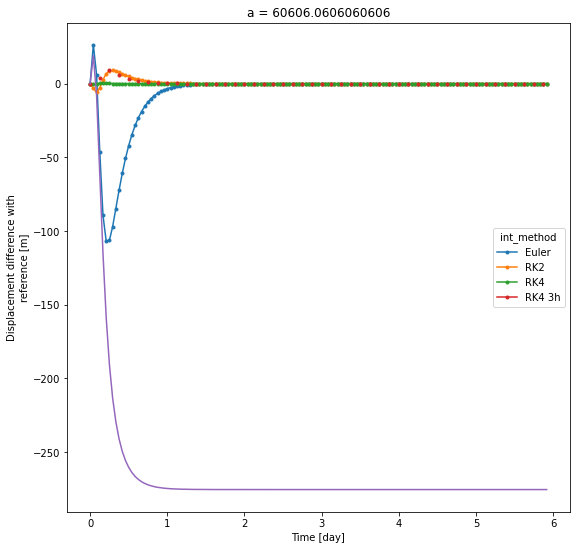

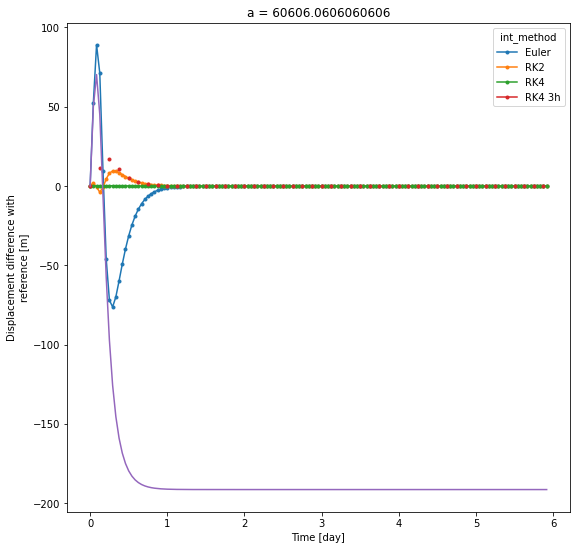

In [3]:
for ki in K:
    z=sti.SetUp(advected=0)
    z.update_parameters(velocity__k=ki)
    compz=sti.Temp_Int_Comp(z,advected=0,k=ki)
    compz.print_diff_dis(traj=30)
    t=z.out_ds.otime
    zp=z['p'].isel(a=30)
    z0=z['p'].isel(a=30, otime=0)
    err=z['uw']*sti.h2s/2*(xr.ufuncs.cos(z['k']*z0)-xr.ufuncs.cos(z['w']*t-z['k']*zp))
    #err=z['uw']*sti.h2s/2/2*(xr.ufuncs.cos(z['k']*(zp-z['um']*t))-xr.ufuncs.cos(z['w']*t-z['k']*(zp-z['um']*t)))
    err.attrs={'units':'m', "long_name":"Displacement difference with reference"}
    otime_day = err.otime/(24*3600)
    err.coords['otime_day']=otime_day
    err.otime_day.attrs={"units":"day", "long_name":"Time"}
    err.plot(x='otime_day')


## Error dependency on parameters for advected case

In [29]:
dsa=sti.dependency_comp_ds(list_Var=Var, OT=OT, T=T, Dt=Dt, advected=1)

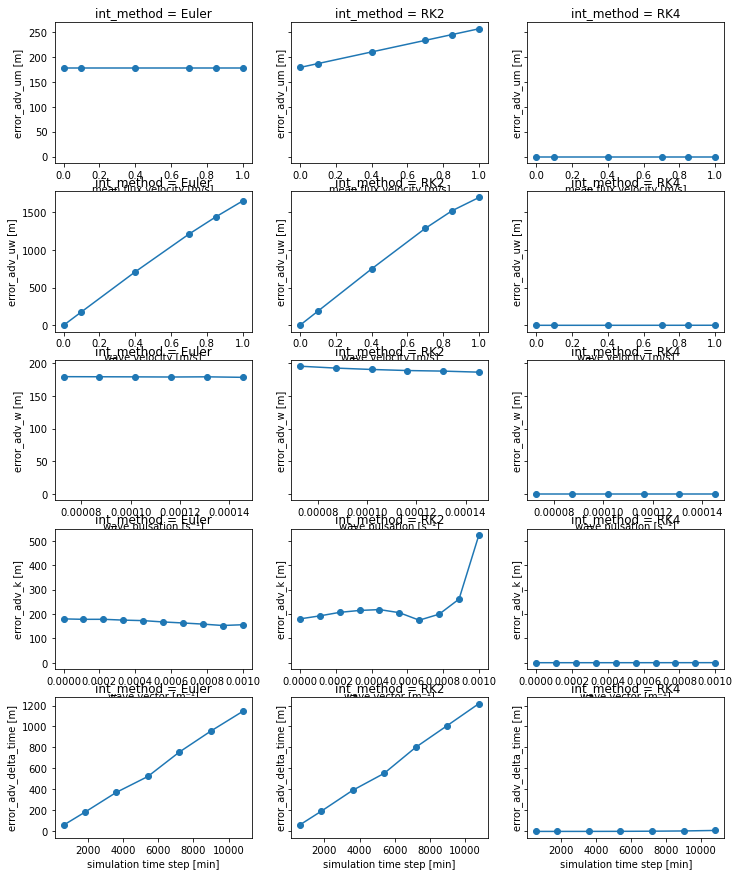

In [16]:
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=(12,15), sharey='row')
method=['Euler','RK2', 'RK4']
for i in range(3):
    dsa.error_adv_um.sel(int_method=method[i]).plot(ax=axes[0][i], marker='o')
    dsa.error_adv_uw.sel(int_method=method[i]).plot(ax=axes[1][i], marker='o')
    dsa.error_adv_w.sel(int_method=method[i]).plot(ax=axes[2][i], marker='o')
    dsa.error_adv_k.sel(int_method=method[i]).plot(ax=axes[3][i], marker='o')
    dsa.error_adv_delta_time.sel(int_method=method[i]).plot(ax=axes[4][i], marker='o')

No significative difference on amplitude difference compared to the unadvected case -> NEED TO STUDY THE PERIODICITY

In [17]:
def error_func(y):
    t=y.out_ds.otime
    yp=y['p'].isel(a=20)
    y0=y['p'].isel(a=20, otime=0)
    if y.out_ds.velocity__advected==0:
        return y['uw']*sti.h2s/2/2*(xr.ufuncs.cos(y['k']*y0)-xr.ufuncs.cos(y['w']*t-y['k']*y0))
    else:
        return y['uw']*sti.h2s/2/2*(xr.ufuncs.cos(y['k']*(yp-y['um']*t))-xr.ufuncs.cos(y['w']*t-y['k']*(zp-y['um']*t)))
        